In [1]:
# !pip3 install scikit-learn termcolor

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn as skl
from termcolor import colored
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.decomposition import PCA

# Classification

Suppose we have a set of objects, described by their features $x^{(k)}$, and labels $l^{(k)}$ assigned to the objects.
Doing statistical classification we find the rule $f$ that maps $x^{(k)}$ to $l^{(k)}$ and generalize the rule to all possible objects.
For example, given samples of handwritten digits, problem of statistical classification is to assign the correct digit to an arbitrary character.

From mathematical point of view, the classifier $f$ is a mapping from the vector space $\mathbb R^N$ of all features $x$  to the vector space $\mathbb R^M$ of scores $p$, where $N$ is the number of features, and $M$ is the number of classes. In the simplest case the output of the classifier can be the class/label $l$ itself, but usage of scores instead of labels have several benefits: (1) the score shows confidence in the result, (2) scores are differentiable what is a desirable property for machine learning, (3) cross-entropy loss function can be used. 
It is convenient to consider score $p_l$ as the probability of $x$ to belong to the class $l$, therefore $p$ should be properly normalized: 
$p_l\geq 0$, $\sum_l p_l=1$.

In ML the classifier $f(\cdot|\theta)$ is taken from a predefined set, chosen to match known properties of the problem. 
Then the parameters $\theta$ of the classifier are tuned to match the training set $x^{train,k}$, $p^{train,k}$ in the best possible way.
Two method are most popular for training the classifier: (1) point estimation of $\theta$, e.g. maximum likelyhood method, and (2) Bayesian inference capable of estimation of probability distribution of $\theta$.

## Point estimation

Suppose $f(x|\theta)=p$ is the probability destribution of $x$ to belong to each class for specified parameters $\theta$ of the classifier.
If the exact distribution is known, denote it by $\hat p(x)$, than the performance of the classifier can be estimated by the cross entropy function:
$$
H(p,\hat p)=-\sum_l p_l\log \hat p(x)_l.
$$
In applications the distribution is rarely known, instead samples $l^{k}$ of $p(x)$ are known.
In the case the cross entropy can be estimated by the following statistics:
$$
H(p,\hat p)\approx -S^{-1}\sum_k \log \hat p(x)_{l^{(k)}},
$$ 
where $S$ is total number of samples.
To estimate the performance of the estimate $\theta$ on all objects $x$, 
an averaging over all $x$ is applied, 
$$
E_x[H|\theta]\approx L[x,y|\theta]=-S^{-1}\sum_k \log \hat p(x^{(k)})_{l^{(k)}}. 
$$
The training of the classifier is just minimization of the loss function on the training set:
$$
\hat\theta = \mathrm{argmin}_\theta L[x^{train,k}|\theta), y^{train,k}|\theta].
$$



One of the simplest classifiers is linear classifier. Assume that there are only two possible classes for $x$ to belong to. 
Than the distribution $p$ is defined by the single value $p_0\in[0,1]$ defining the probability of $x$ to belong to the class $0$.
The linear classifier assumes that classes are separated by a hyperplane, therefore the score is computed by:
$$
p_0(x|\theta)=f(x\cdot\theta)=f(\sum_j x_j \theta_j),
$$
where common choice for the activatio function $f$ are step function and logistic function:
$$
f(a)=(1+e^{-x})^{-1}.
$$
Applying a fixed non-linear transform $T$ to the points $x$ before evaluation of the inner product,
$$
p_0(x|\theta)=f(T(x)\cdot\theta)=f(\sum_j T(x)_j \theta_j),
$$
effectively transforms the dividing hyperplane to arbitrary complex hypersurface, 
thus hugely increasing class of the problems solvable by the linear regression.
The transform $T$ can even map every element $x$ to several features, e.g. polynomial basis,
allowing reconstruction of almost arbitrary dependence in data.
Increasing number of features can potentialy significantly slow down computation,
but [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) can be used to even infinite number of features without overhead.




## Performance metrics

Performance of the classifier can be estimated using [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) 
and derived metrics such as [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) for binary classifiers.
The metrics can be misleading, if the data is unbalanced, that is if numbers of postive and negative cases are significantly different. 

If a classifier returns score for each class, than boundary between classes are determined by the threshold value. 
The best possible value can be estimated from [Receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic),
which is dependence of true positive cases on false positive. 
The best threshold corresponds to upper left point on the plot.
The area under the ROC curve is also used to compare different classifiers.


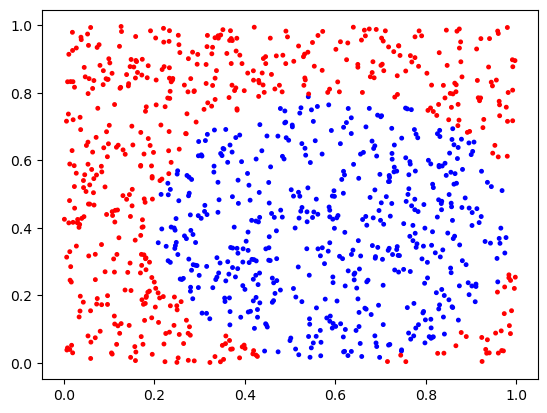

In [3]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

def visualize(x=None, y=None, y_predicted=None, axis=None):
    nitems = x.shape[0]
    assert y.shape == (nitems,)
    assert x.ndim == 2 

    if y_predicted is not None:
        assert y_predicted.shape == y.shape
        wrong_predictions = y!=y_predicted
    else:
        wrong_predictions = slice(0)
    
    if axis is None:
        _fig, axis = plt.subplots()
        
    if x.shape[1] == 2: # Scatter plot vizualization
        axis.scatter(x=x[wrong_predictions,0], y=x[wrong_predictions,1], c="#FFD700", marker=',', s=30)
        axis.scatter(x=x[:,0], y=x[:,1], c=y, cmap=cm_bright, edgecolor=None, marker='.', s=25)
    else: # Function plot
        axis.plot(x[wrong_predictions,:].T, c="#DFFF00", linestyle='solid', linewidth=5, alpha=1)
        axis.plot(x[y==0,:].T, linestyle='solid', color="#FF0000")
        axis.plot(x[y==1,:].T, linestyle='solid', color="#0000FF")        
        
        

class TestProblem:
    def sample(self, nitems: int) -> (np.ndarray, np.ndarray):
        raise NotImplementedError

    def visualize(self, nitems=1000, axis=None):
        x, y = self.sample(nitems=nitems)
        visualize(x=x, y=y, axis=axis)

class CircleProblem(TestProblem):
    def __init__(self, center: np.ndarray, radius: float):
        self._center = np.array(center)
        assert self._center.ndim == 1
        self._radius = np.float32(radius)

    def sample(self, nitems):
        x = np.random.rand(nitems, self._center.shape[0])
        distance_to_the_center = np.linalg.norm(x-self._center[None], ord=2, axis=-1)
        y = distance_to_the_center<self._radius
        return x, y

problem = CircleProblem(center=(0.6, 0.4), radius=0.4)
problem.visualize()
plt.show()

Training data:
Confusion matrix:
 [[479  13]
 [ 11 497]]
Recall 97.36%, precision 97.76%, f1-measure 97.56%
Test data:
Confusion matrix:
 [[56  1]
 [ 1 42]]
Recall 98.25%, precision 98.25%, f1-measure 98.25%


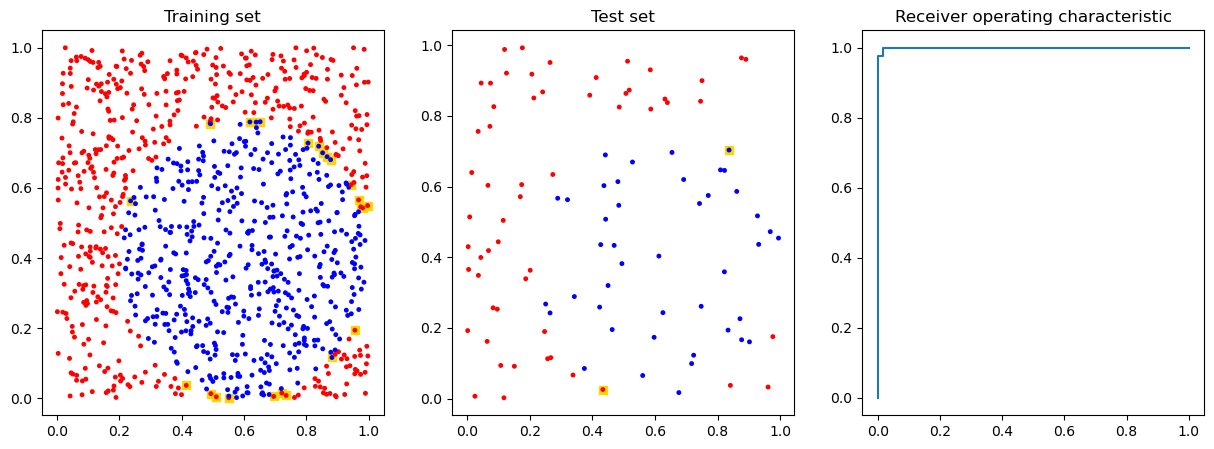

In [4]:
from sklearn import metrics

def confusion_matrix(y, y_predicted):
    mx = np.maximum(np.max(y),np.max(y_predicted))
    confusion_matrix = np.zeros((mx+1, mx+1), dtype=np.int32)
    for r, c in zip(y,y_predicted):
        confusion_matrix[r,c] += 1
    return confusion_matrix

def print_metrics(y, y_predicted):
    y = np.array(y, dtype=np.int8)
    y_predicted = np.array(y_predicted, dtype=np.int8)
    
    cm = confusion_matrix(y,y_predicted)
    print(f"Confusion matrix:\n", cm)

    if cm.shape[0]==2:
        (TP, FN), (FP, TN) = cm
        recall = TP/(TP+FN)
        precision = TP/(TP+FP)
        f1 = 2*TP/(2*TP+FP+FN)
        print(f"Recall {100*recall:.2f}%, precision {100*precision:.2f}%, f1-measure {100*f1:.2f}%")

def benchmark_classifier(clf, problem, n_training_samples=1000, n_test_samples=100):
    training_x, training_y = problem.sample(nitems=n_training_samples)
    test_x, test_y = problem.sample(nitems=n_test_samples)

    clf.fit(training_x, training_y)

    y_predicted = clf.predict(training_x)
    y_predicted_test = clf.predict(test_x)

    print(colored("Training data:","yellow"))
    print_metrics(training_y, y_predicted)

    print("Test data:")
    print_metrics(test_y, y_predicted_test)


    fig, (axis1, axis2, axis3) = plt.subplots(ncols=3, figsize=(15, 5))

    visualize(training_x, training_y, y_predicted, axis=axis1)
    axis1.set_title('Training set')

    visualize(test_x, test_y, y_predicted_test, axis=axis2)
    axis2.set_title('Test set')

    scores = clf.decision_function(test_x)
    fpr, tpr, thresholds = metrics.roc_curve(test_y, scores)
    axis3.plot(fpr, tpr)
    axis3.set_title('Receiver operating characteristic')

    plt.show()



from sklearn import svm
clf = svm.SVC()
benchmark_classifier(clf, problem)


## Problems:

1. `CircleProblem` above is an example of complete separation problem, that is a unique class is assigned deterministically to every features vector. In many cases however the boundary between the classes are blured or the classes overlap. That means that in general only probability distribution of the classes can be defined. 
As an example, consider a test binary classification problem `GaussProblem`, such that an object described by a vector from $\mathbb R^N$ belongs to the first (positives) class with the probability defined by the [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). The class of every object in the training/test is uniquely defined, despite the fact that the same object can belong to different classes on multiple occurances in the set. Define a class implementing the problem settings.

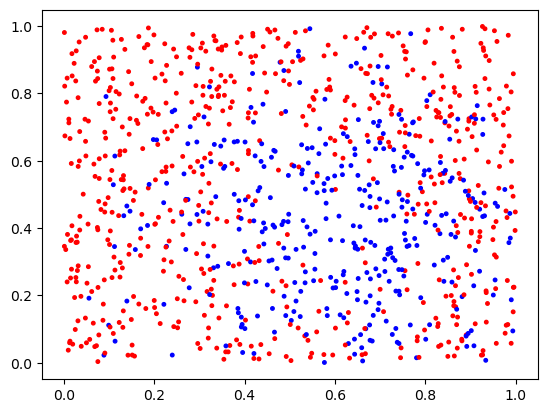

In [5]:
class GaussProblem(TestProblem):
    def __init__(self, center: np.ndarray, radius: float):
        self._center = np.array(center)
        assert self._center.ndim == 1
        self._radius = np.float32(radius)
        
    def score(self, points):
        assert points.ndim==2 and points.shape[1]==self._center.shape[0]
        distance_to_center_squared = np.sum( (points-self._center[None])**2, axis=-1)
        return np.exp(-distance_to_center_squared/(2*self._radius**2))

    def sample(self, nitems):
        x = np.random.rand(nitems, self._center.shape[0])
        zero_class_probability = self.score(x)
        y = np.random.rand(nitems)<=zero_class_probability
        return x, y

problem = GaussProblem(center=(0.6, 0.4), radius=0.25)
problem.visualize()
plt.show()

2. Boundary between the classes in `GaussProblem` is blured in contrast to `CircleProblem`. How does the bluring affect classification metrics?

3. Check parameters of the classifiers and tune them to avoid overfitting.

4. Compare classifiers [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) impl, [k-nearest neighbors algorithm
](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), 
[`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) impl. [support-vector_machine](https://en.wikipedia.org/wiki/Support-vector_machine) with different kernels, 
[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) impl. [random forest method](https://ru.wikipedia.org/wiki/Random_forest)
from sklearn on `GaussProblem`, you may found usefull [this example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Explain difference in the performance of the classifiers.

5. Derive class `EllipseProblem` from `TestProblem` that generates plots of Ellipse. Increase dimensionality of the features space and use `KNeighborsClassifier`, do you see any effects of [curse of dimensionality?](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

6. Select [important features](https://en.wikipedia.org/wiki/Feature_selection) used by the classifier for `FunctionProblem`. Apply the [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) and visualize the result. Try to eliminate all features except of the important ones, and check performance of the classifier on the important features. Can you explain, how the classifier decides which class an example belongs to?

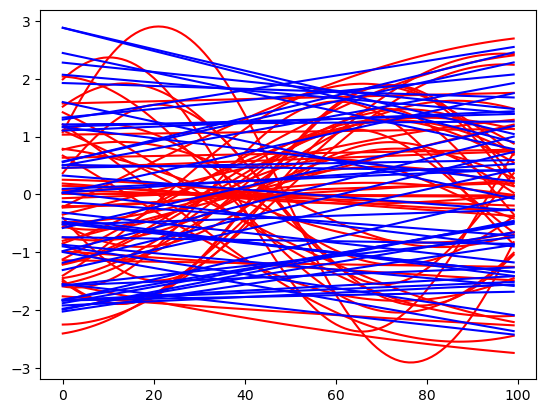

In [6]:
class FunctionProblem(TestProblem):
    def __init__(self, N: int):
        self._N = np.int32(N)
        assert self._N>0
        self._t = np.linspace(-.5,0.5,self._N)
     
    @property
    def t(self):
        return self._t
    
    def sample_zero_class(self, nitems):
        A = np.random.uniform(-3., 3., size=nitems)[:,None]
        B = np.random.uniform(0., 2*np.pi, size=nitems)[:,None]
        C = np.random.uniform(0., 1., size=nitems)[:,None]
        return A*np.sin(B*self.t[None]+C)
    
    def sample_first_class(self, nitems):
        D = np.random.uniform(-2., 2., size=nitems)[:,None]
        E = np.random.uniform(-2., 2., size=nitems)[:,None]
        return D*self.t[None]+E
    
        
    def sample(self, nitems):
        nitems0 = nitems//2
        nitems1 = nitems - nitems0
        x = np.concatenate((self.sample_zero_class(nitems0), self.sample_first_class(nitems1)), axis=0)
        y = np.concatenate((np.zeros(nitems0), np.ones(nitems1)), axis=0)
        assert x.shape == (nitems, self._N)
        assert y.shape == (nitems,)        
        perm = np.random.permutation(nitems)
        return x[perm], y[perm]
    
problem = FunctionProblem(N=100)
problem.visualize(100)
plt.show()

**Problem 2**
Boundary between the classes in `GaussProblem` is blured in contrast to `CircleProblem`. How does the bluring affect classification metrics?



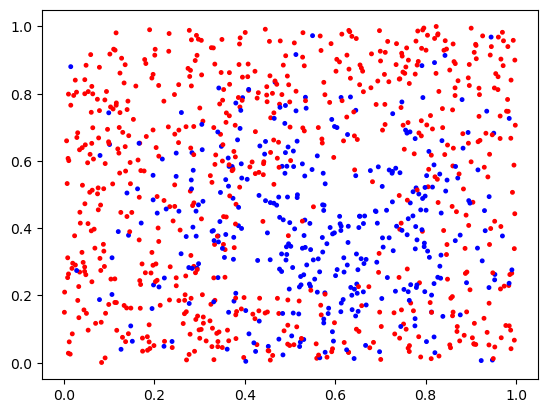

In [7]:
Gauss_problem = GaussProblem(center=(0.6, 0.4), radius=0.25)
Gauss_problem.visualize()
plt.show()

Training data:
Confusion matrix:
 [[612  49]
 [169 170]]
Recall 92.59%, precision 78.36%, f1-measure 84.88%
Test data:
Confusion matrix:
 [[70  5]
 [12 13]]
Recall 93.33%, precision 85.37%, f1-measure 89.17%


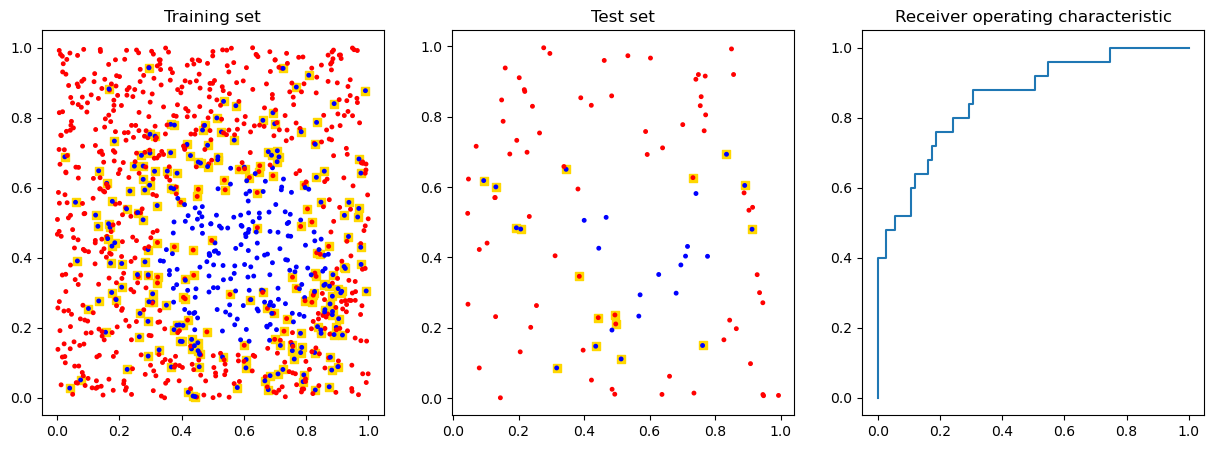

In [8]:
clf = svm.SVC()
benchmark_classifier(clf, Gauss_problem)

Можно видеть, что в случае, когда точная граница между классами отсутствует, значения всех метрик имеют более низкие значения (в том числе площадь под ROC-curve). Это происходит потому, что при использовании метода SVM для задачи классификации подразумевается, что классы разделены четкой границей, однако в этом случае это не так.

**Problem 3**

Check parameters of the classifiers and tune them to avoid overfitting.

Чтобы избежать переобучения, построим зависимость значения метрики accuracy от параметра $\gamma$, входящего в ядро ([примеры использования разных ядер для задачи классификации](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py))

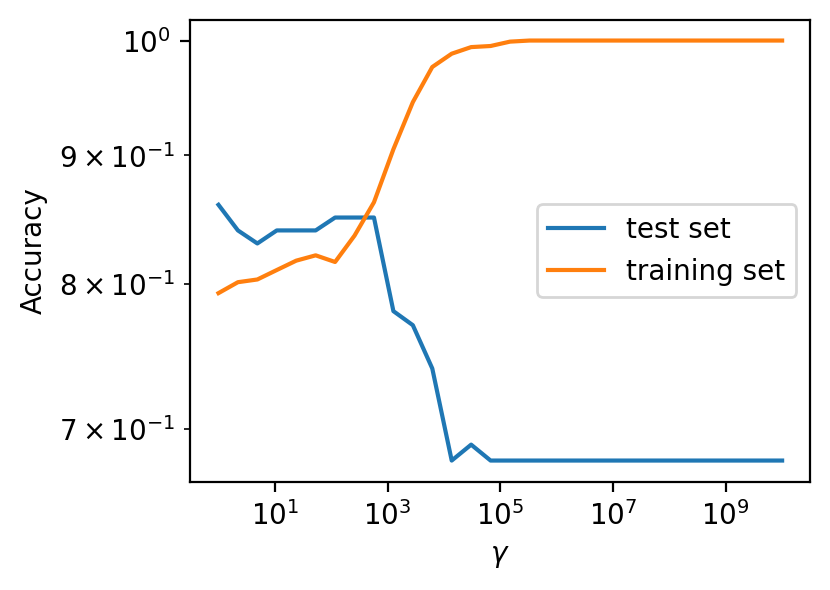

In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

gammas = np.logspace(0, 10, 30)
np.random.seed(1)
n_training_samples=1000
n_test_samples=100

clf = svm.SVC() 
training_x, training_y = Gauss_problem.sample(nitems=n_training_samples)
test_x, test_y = Gauss_problem.sample(nitems=n_test_samples)

acc_arr = np.zeros((2, len(gammas)))

for n, g in enumerate(gammas):
    clf = svm.SVC(gamma=g)
    clf.fit(training_x, training_y)
    y_predicted_test = clf.predict(test_x)
    acc_arr[0, n] = accuracy_score(test_y, y_predicted_test)
    acc_arr[1, n] = accuracy_score(training_y, clf.predict(training_x))

fig = plt.figure(figsize=(4, 3), dpi=200)
plt.loglog(gammas, acc_arr[0], label="test set")
plt.loglog(gammas, acc_arr[1], label="training set")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel(fr"$\gamma$")
plt.show()

По графику зависимости $\text{accuracy}(\gamma)$, можно сделать вывод, что при значениях $\gamma > 10^4$ модель переобучается.
Для наглядности визуализируем результат работы модели на тестовом и тренировочном наборах для значения $\gamma = 10^7$

Training data:
Confusion matrix:
 [[657   0]
 [  0 343]]
Recall 100.00%, precision 100.00%, f1-measure 100.00%
Test data:
Confusion matrix:
 [[66  0]
 [34  0]]
Recall 100.00%, precision 66.00%, f1-measure 79.52%


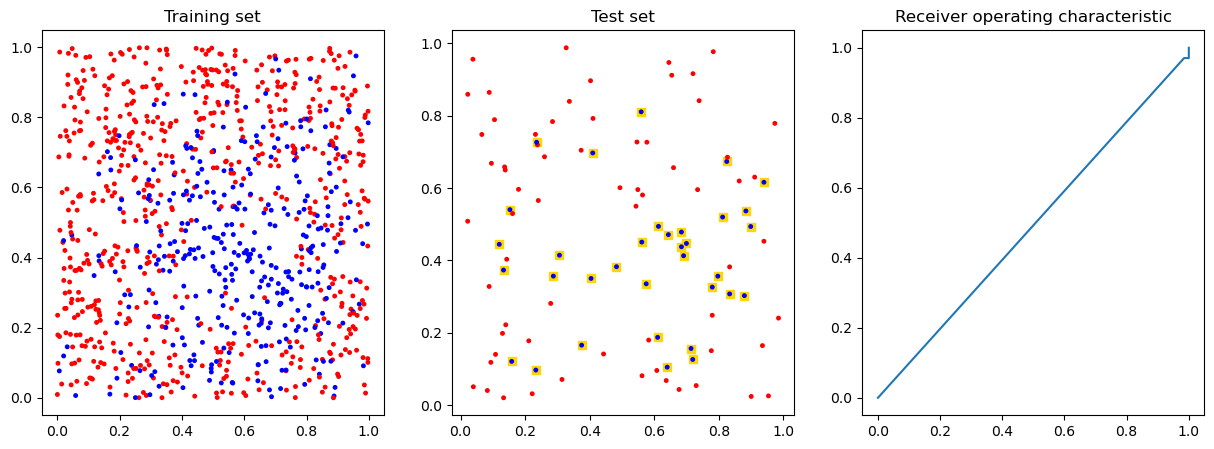

In [10]:
benchmark_classifier(svm.SVC(gamma=1e07), Gauss_problem)

**Problem 4**

Compare classifiers [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) impl, [k-nearest neighbors algorithm
](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), 
[`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) impl. [support-vector_machine](https://en.wikipedia.org/wiki/Support-vector_machine) with different kernels, 
[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) impl. [random forest method](https://ru.wikipedia.org/wiki/Random_forest)
from sklearn on `GaussProblem`, you may found usefull [this example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Explain difference in the performance of the classifiers.

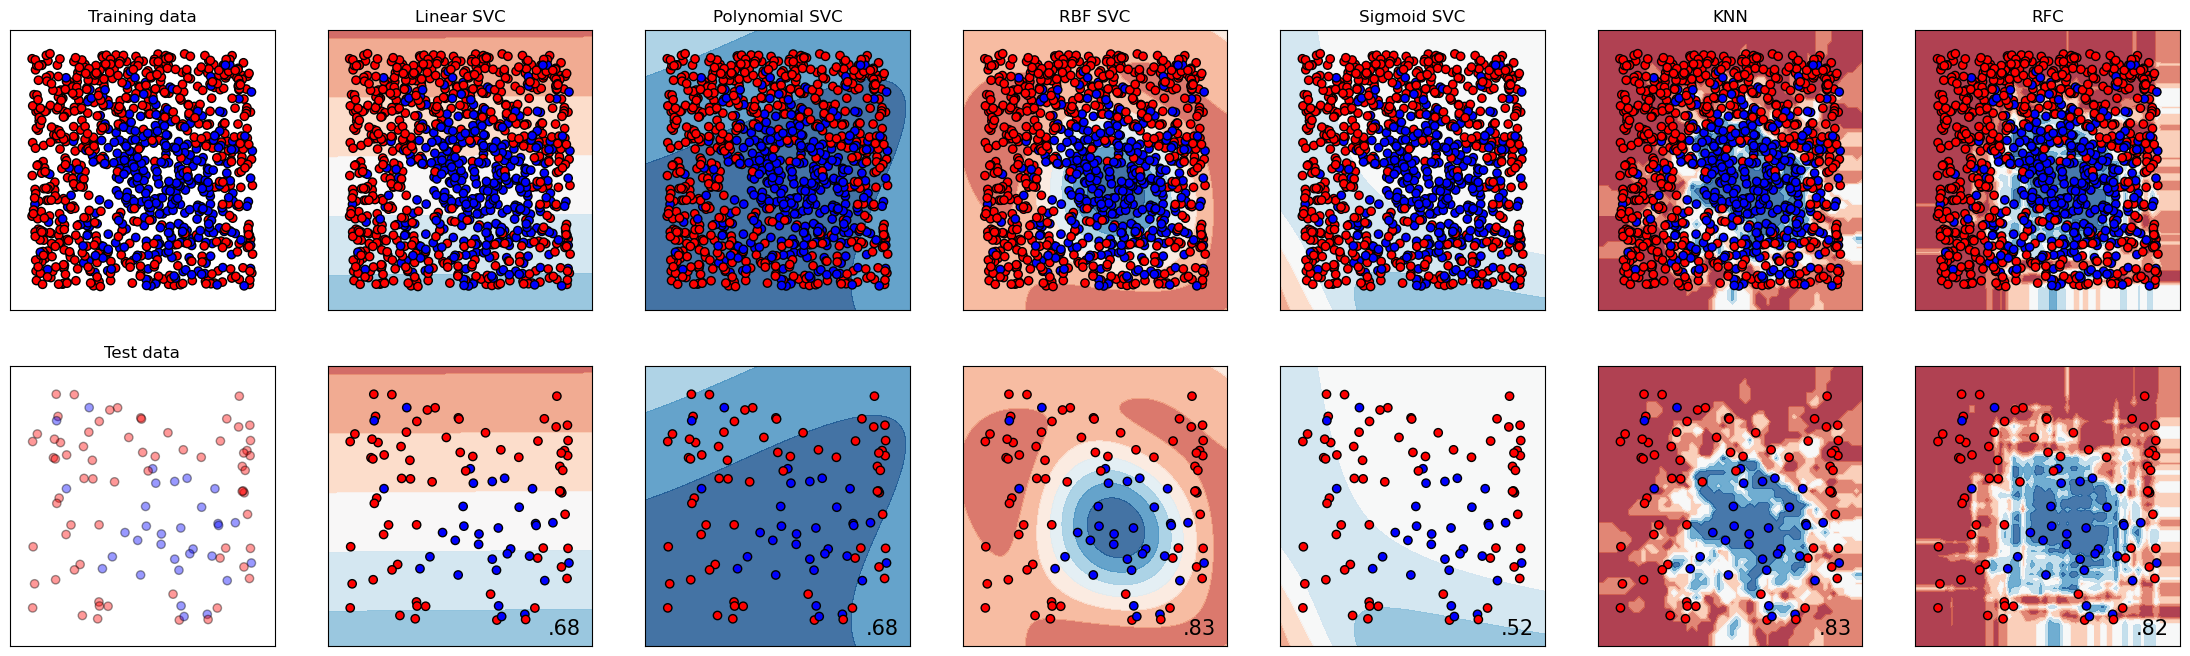

In [11]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Linear SVC",
    "Polynomial SVC",
    "RBF SVC",
    "Sigmoid SVC",
    "KNN",
    "RFC"
]

classifiers = [
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    KNeighborsClassifier(),
    RandomForestClassifier()
]

datasets = [
    (training_x, training_y),
    (test_x, test_y)
]

figure = plt.figure(figsize=(28, 8))

x_min, x_max = training_x.min() - 0.1, training_x.max() + 0.1
y_min, y_max = training_y.min() - 0.1, training_y.max() + 0.1

i = 1

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

for ds_cnt, (x, y) in enumerate(datasets):
    # just plot the dataset first
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    
    if ds_cnt == 0:
        ax.set_title("Training data")
        # Plot the training points
        ax.scatter(x[:, 0], x[:, 1], c=training_y, cmap=cm_bright, edgecolors="k")
    else:
        # Plot the testing points
        ax.set_title("Test data")
        ax.scatter(
            x[:, 0], x[:, 1], c=test_y, cmap=cm_bright, alpha=0.4, edgecolors="k"
        )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(training_x, training_y)
        score = clf.score(test_x, test_y)
        DecisionBoundaryDisplay.from_estimator(
            clf, x, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )
        ax.scatter(
            x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors="k"
        )
        
        if ds_cnt == 0:
            ax.set_title(name)
            
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        
        if ds_cnt == 1:
            ax.text(
                x_max - 0.05,
                y_min + 0.05,
                ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )
        
        i += 1


plt.show()

**Problem 5**
Derive class `EllipseProblem` from `TestProblem` that generates plots of Ellipse. Increase dimensionality of the features space and use `KNeighborsClassifier`, do you see any effects of [curse of dimensionality?](https://en.wikipedia.org/wiki/Curse_of_dimensionality)


In [12]:
class EllipseProblem(TestProblem):
    def __init__(self, center: np.ndarray, semi_axes: np.ndarray):
        self._center = np.array(center)
        self._semi_axes = np.array(semi_axes)
        assert self._center.ndim == 1
        assert self._center.shape == self._semi_axes.shape

    def sample(self, nitems):
        x = np.random.rand(nitems, self._center.shape[0])
        y = np.zeros(nitems)
        for i in np.arange(len(self._center)):
            y += ((x[:, i] - self._center[i]) / self._semi_axes[i])**2
        y = y < 1
        return x, y

In [13]:
np.random.seed(1)
n_training_samples=10000
n_test_samples=1000
clf = KNeighborsClassifier()
max_dim = 10
centers = np.ones(max_dim) * 0.5
semi_axes = np.random.uniform(0.3, 0.5, max_dim)

for i in range(2, max_dim + 1):
    Ellipse_problem = EllipseProblem(center=centers[:i], semi_axes=semi_axes[:i])
    training_x, training_y = Ellipse_problem.sample(nitems=n_training_samples)
    test_x, test_y = Ellipse_problem.sample(nitems=n_test_samples)
    clf.fit(training_x, training_y)
    y_predicted = clf.predict(test_x)
    print(colored(f"dim = {i}", "red"))
    print_metrics(test_y, y_predicted)
    

dim = 2
Confusion matrix:
 [[468   8]
 [  2 522]]
Recall 98.32%, precision 99.57%, f1-measure 98.94%
dim = 3
Confusion matrix:
 [[755  10]
 [  8 227]]
Recall 98.69%, precision 98.95%, f1-measure 98.82%
dim = 4
Confusion matrix:
 [[902   6]
 [ 12  80]]
Recall 99.34%, precision 98.69%, f1-measure 99.01%
dim = 5
Confusion matrix:
 [[969   0]
 [ 15  16]]
Recall 100.00%, precision 98.48%, f1-measure 99.23%
dim = 6
Confusion matrix:
 [[994   0]
 [  3   3]]
Recall 100.00%, precision 99.70%, f1-measure 99.85%
dim = 7
Confusion matrix:
 [[997   0]
 [  1   2]]
Recall 100.00%, precision 99.90%, f1-measure 99.95%
dim = 8
Confusion matrix:
 [[1000]]
dim = 9
Confusion matrix:
 [[1000]]
dim = 10
Confusion matrix:
 [[1000]]


Можно видеть, что при повышении размерности пространства количество точек в тестовой выборке становится недостаточным для корректной работы `KNeighborsClassifier` (плотность точек слишком низкая). Таким образом, можно сделать вывод, что наблюдается явление [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) при повышении размерности пространства.

**Problem 6**
Select [important features](https://en.wikipedia.org/wiki/Feature_selection) used by the classifier for `FunctionProblem`. Apply the [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) and visualize the result. Try to eliminate all features except of the important ones, and check performance of the classifier on the important features. Can you explain, how the classifier decides which class an example belongs to?

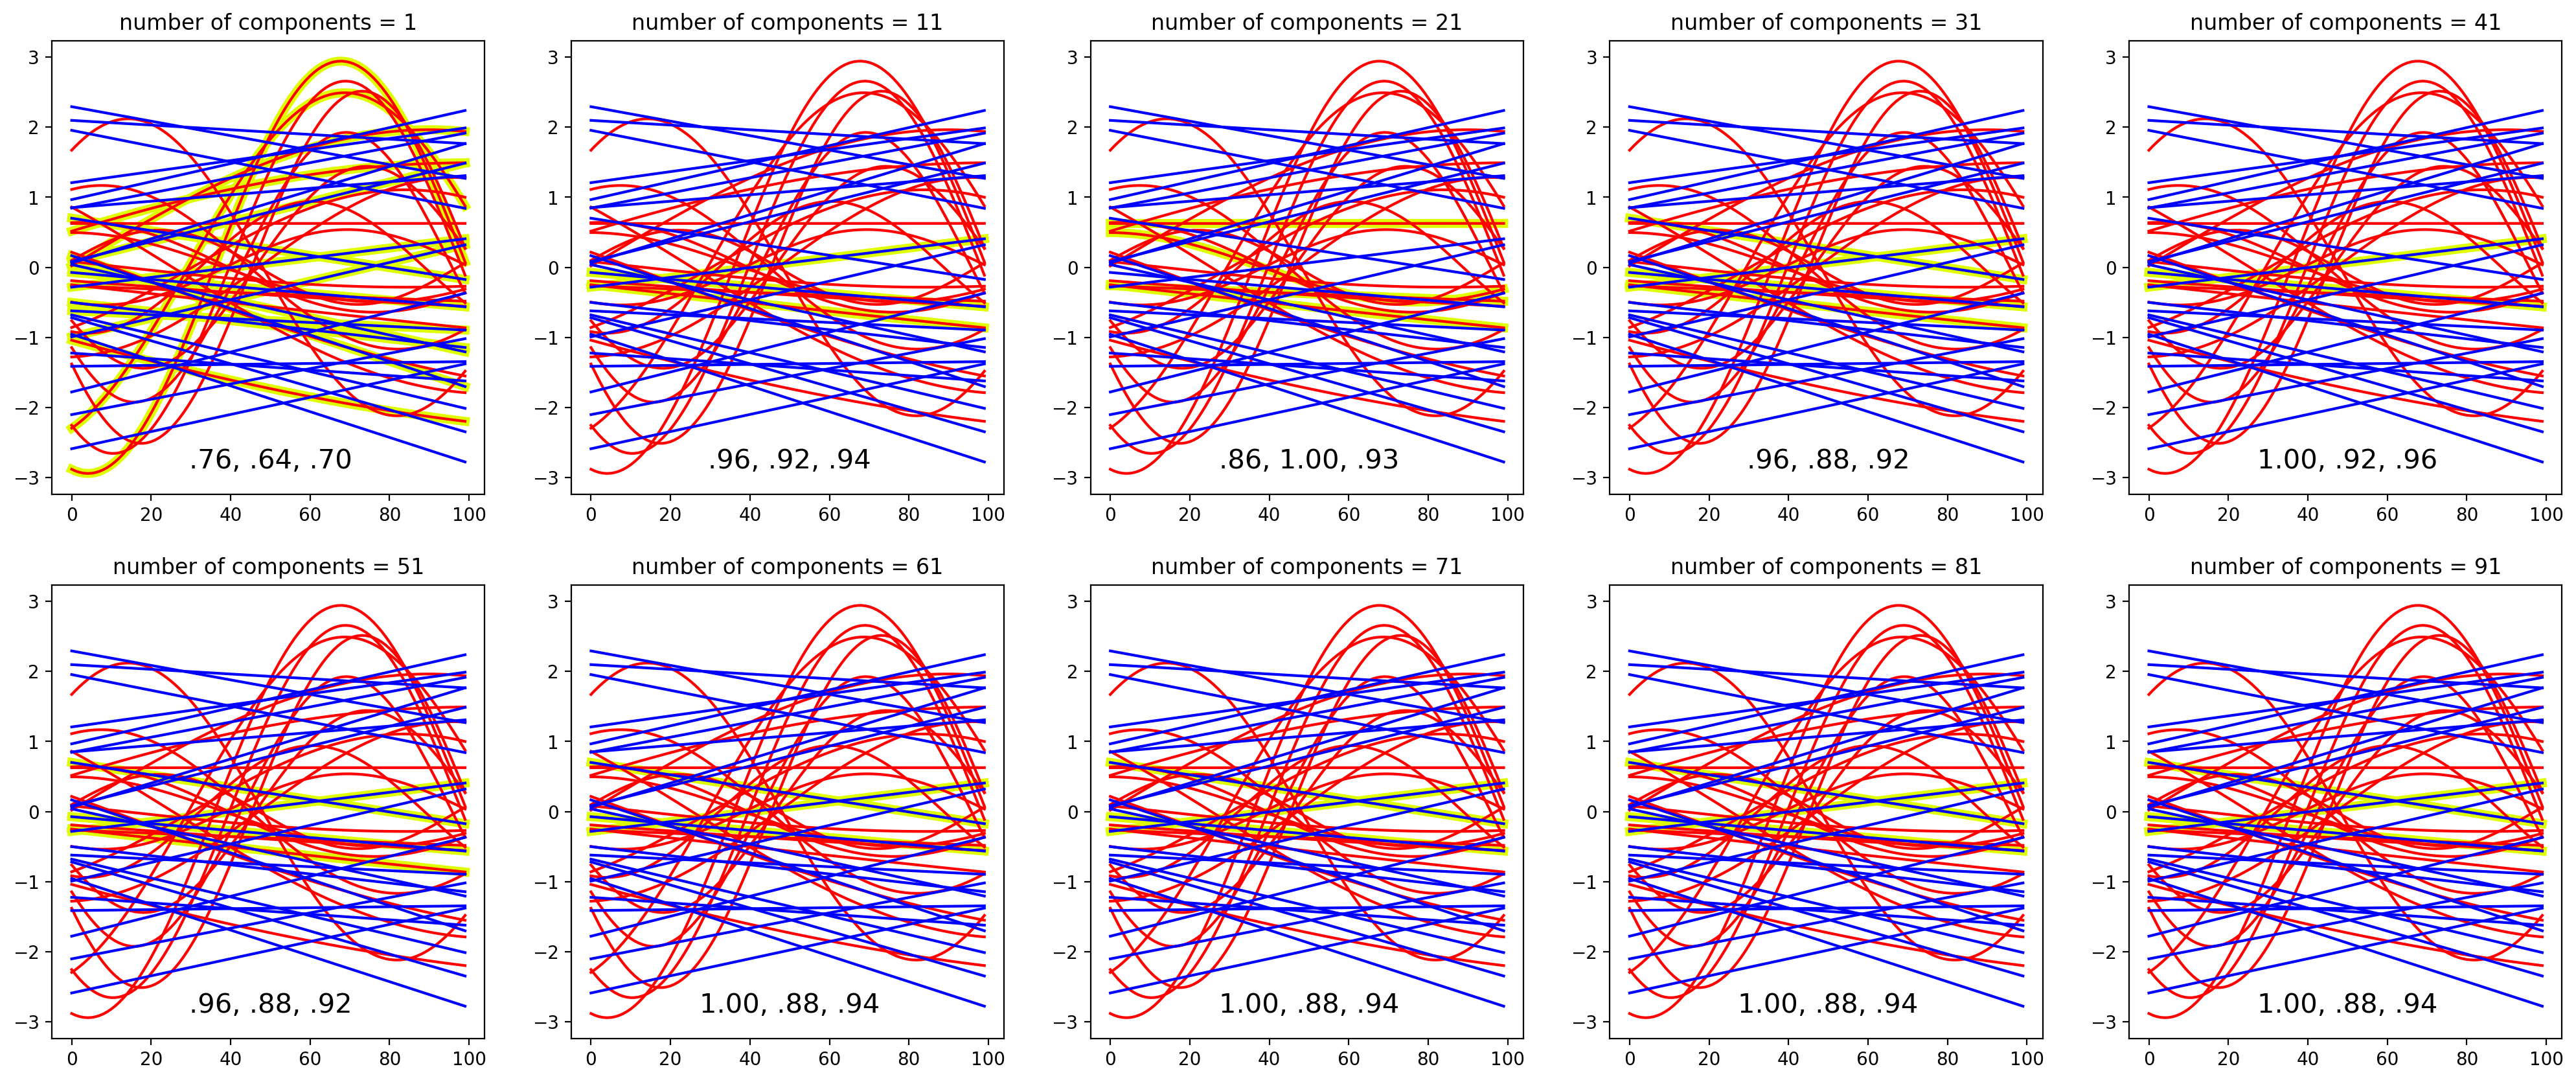

In [14]:
from sklearn.decomposition import PCA

np.random.seed(0)
num_of_features = 100
Func_problem = FunctionProblem(N=num_of_features)
func_training_x, func_training_y = Func_problem.sample(500)
func_test_x, func_test_y = Func_problem.sample(50)

x_min, x_max = func_training_x.min() - 0.1, func_training_x.max() + 0.1

figure = plt.figure(figsize=(25, 10), dpi=200)
j = 1
for i in np.arange(1, num_of_features + 1, 10):
    ax = plt.subplot(2, num_of_features // 20, j)
    
    pca = PCA(n_components=i, whiten=True)
    pca.fit(func_training_x)
    func_training_x_red = pca.transform(func_training_x)
    func_test_x_red = pca.transform(func_test_x)

    clf = SVC()
    clf.fit(func_training_x_red, func_training_y)

    func_y_predicted = clf.predict(func_test_x_red)

    visualize(func_test_x, func_test_y, func_y_predicted, axis=ax)
    recall = recall_score(func_y_predicted, func_test_y)
    precision = precision_score(func_y_predicted, func_test_y)
    f1 = f1_score(func_y_predicted, func_test_y)
    ax.text(
                50,
                x_min + 0.2,
                ", ".join([("%.2f" % recall).lstrip("0"), ("%.2f" % precision).lstrip("0"), ("%.2f" % f1).lstrip("0")]),
                size=15,
                horizontalalignment="center",
            )
    ax.set_title(f"number of components = {i}")
    j += 1

plt.show()

В нижней части графика указаны значения recall, precision и f1 метрик соответственно